# Optimization techniques Lab. 6: Bayesian Optmization
## Introduction
**Goal.** The goal of this lab is to study the behavior of Bayesian optimization on a regression problem and a classifier one. 
Bayesian optimization is a probabilistic approach that uses the Bayes' Theorem $P(A|B) = \frac{P(B|A)*P(A)}{P(B)}$. Briefly, we use the prior information, P(A),(random samples) to optimize a surrogate function, P(B|A).

**Getting started.** The following cells contain the implementation of the methods that we will use throughout this lab, together with utilities. 


In [1]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 10.6 MB/s 


In [2]:
# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from warnings import catch_warnings
from skopt import gp_minimize
from warnings import simplefilter

In [3]:


# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = acquisition_function(mu,std,best)
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()


def bayesianOptmization(generation):
    # sample the domain sparsely with noise
    X , y  = initial_point(size = 100)
    # reshape into rows and cols
    X = X.reshape(len(X), 1)
    y = y.reshape(len(y), 1)
    # define the model
    model = GaussianProcessRegressor() #you can set the kernel and the optmizer 
    # fit the model
    model.fit(X, y)
    # perform the optimization process
    for i in range(generation):
        # select the next point to sample
        x = opt_acquisition(X, y, model)
        # sample the point
        actual = objective(x)
        # summarize the finding
        est, _ = surrogate(model, [[x]])
        # add the data to the dataset
        X = vstack((X, [[x]]))
        y = vstack((y, [[actual]]))
        # update the model
        model.fit(X, y)
    return X, y, model

#Implementative part.
Your first step, will be to implement the following functions:


1.   objective() is the function to optimize. 
2.   initial_point() returns the initial set of points (a priori knowledge)
3.   acquisition_function() implements the acquisition function




In [4]:
# objective function
def objective(x, noise=0.1):
	return x + normal(loc=0, scale=noise)

#remember to return the value in the right order and type.
def initial_point(size = 100):
    X = random(size)
    Y = asarray([objective(x) for x in X])
    return X, Y

#you have to add the parameters that you need.
def acquisition_function(mu, std, best):
    return norm.cdf((mu - best) / (std + 1E-9))

# Regression
---
## Questions:
- How does the prior knowledge change the optimization?
- How does the kernel change the optimization? (see here the [kernels](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes))
- ow does the acquisition function affect the optimization?

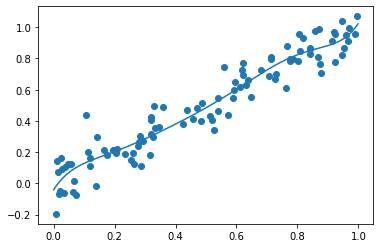

Best Result: x=0.997, y=1.071


In [5]:
X, y, model = bayesianOptmization(1)
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

# Classifier
---
## Questions:
- Try different ranges of hyperparameters. How do the results change?
- Does the model influence the choice of the hyperparameters?



In [7]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2)
# define the model

model = KNeighborsClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 5, name='n_neighbors'), Integer(1, 2, name='p')]

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    # something
    model.set_params(**params)
    # calculate 5-fold cross validation
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
        # calculate the mean of the scores
        estimate = mean(result)
        return 1.0 - estimate
        
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

Best Accuracy: 0.920
Best Parameters: n_neighbors=4, p=2


# BONUS

You see in the classifier the effect of hyperparameter tuning. 
You can now change the acquisition functions in the regression problem, adding a slack variable as a hyperparameter. How does this variable affect the optimization problem?